In [3]:
from datasets import load_dataset

ds = load_dataset("Jinyan1/COLING_2025_MGT_multingual")

In [4]:
import pandas

train_df = ds['train'].to_pandas()
dev_df = ds['dev'].to_pandas()

print(train_df.head())
print(dev_df.head())

                                     id source   sub_source lang        model  \
0  808a846d-41c1-46ff-80ab-892b01bec5f3   m4gt        arxiv   en  gemma-7b-it   
1  673ec6fc-624a-4ad5-8d5f-a5950b0e5432   mage           wp   en        human   
2  3059e6e4-1724-4745-a833-cbb6bfb4acd8   mage         xsum   en   flan_t5_xl   
3  4ca1cde7-6dbd-4519-b60c-7f8c8fcd0d36    hc3      open_qa   zh       gpt-35   
4  f9cca231-ed31-45a9-a448-99245f72e32c    hc3  reddit_eli5   en       gpt-35   

   label                                               text  
0      1  This report summarizes the findings of the US ...  
1      0  I've been standing here for days now. Watching...  
2      1  Towell, 25, was knocked down twice during the ...  
3      1  我不确定你想要问的是什么，但是阿玛尼是一个奢侈品牌，它的产品包括化妆品、香水和时装。黑手党是...  
4      1  Sometimes when we eat certain types of food, o...  
                                     id source        sub_source lang   model  \
0  8a6ce8d6-a07c-4a2b-831e-db606a7d46ad   mage              

In [13]:
max_length = 128
from transformers import DistilBertTokenizer, TFDistilBertModel
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
import pickle

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')
distilbert_model = TFDistilBertModel.from_pretrained('distilbert-base-multilingual-cased')

train_texts = train_df['text'].tolist()
train_langs = train_df['lang'].tolist()
train_labels = train_df['label'].values

dev_texts = dev_df['text'].tolist()
dev_langs = dev_df['lang'].tolist()
dev_labels = dev_df['label'].values

with open('/kaggle/input/train-ids/input_ids.pkl', 'rb') as file:
    train_input_ids = pickle.load(file)
with open('/kaggle/input/train-attention/attention_masks.pkl', 'rb') as file:
    train_encodings_attention = pickle.load(file)
with open('/kaggle/input/dev-attention/dev_attention.pkl', 'rb') as file:
    dev_encodings_attention = pickle.load(file)
with open('/kaggle/input/dev-input-ids/dev_input_ids.pkl', 'rb') as file:
    dev_input_ids = pickle.load(file)

Num GPUs Available:  1


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [14]:
def create_classification_model():
    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="attention_mask")
    
    distilbert_outputs = distilbert_model([input_ids, attention_mask])
    pooled_output = distilbert_outputs.last_hidden_state[:, 0]
    
    dense = tf.keras.layers.Dense(128, activation='relu')(pooled_output)
    dropout = tf.keras.layers.Dropout(0.3)(dense)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(dropout)
    
    model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5), 
                  loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

classification_model = create_classification_model()

In [15]:
import numpy as np

classification_model.fit(
    [np.array(train_input_ids), np.array(train_encodings_attention)], 
    np.array(train_labels),
    batch_size=32,
    epochs=1
)

21066/21066 [==============================] - 5050s 238ms/step - loss: 0.2126 - accuracy: 0.9090


In [16]:
classification_model.fit(
    [np.array(train_input_ids), np.array(train_encodings_attention)], 
    np.array(train_labels),
    batch_size=32,
    epochs=1,
    steps_per_epoch = 700
)

700/700 [==============================] - 167s 238ms/step - loss: 0.1232 - accuracy: 0.9528


In [14]:
classification_model.evaluate([np.array(dev_input_ids), np.array(dev_encodings_attention)], np.array(dev_labels))

9028/9028 [==============================] - 760s 84ms/step - loss: 0.1784 - accuracy: 0.9341


[0.1784386932849884, 0.934076189994812]

In [21]:
import numpy as np
import tensorflow as tf
from transformers import DistilBertTokenizer
from sklearn.preprocessing import OneHotEncoder

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')

test_texts = ["i need to sleep i am not good", "我不确定你想要问的是什么，但是阿玛尼是一个奢侈品牌，它的产品包括化妆品、香水和时装。黑手党是指一种犯罪组织"] 
test_langs = ["en", "zh"]  

max_length = 128  
test_encodings = tokenizer(
    test_texts,
    max_length=max_length,
    padding='max_length',  
    truncation=True,  
    return_tensors="tf"  
)

test_input_ids = test_encodings['input_ids']  
test_attention_mask = test_encodings['attention_mask']  

print(f"test_input_ids shape: {test_input_ids.shape}")  
print(f"test_attention_mask shape: {test_attention_mask.shape}") 

test_predictions = classification_model.predict([test_input_ids, test_attention_mask])

predicted_labels = (test_predictions > 0.5).astype(int)

for i, (text, lang, prediction) in enumerate(zip(test_texts, test_langs, predicted_labels)):
    label = 'Machine-Generated' if prediction == 1 else 'Human-Generated'
    print(f"Text: {text}")
    print(f"Language: {lang}")
    print(f"Predicted Label: {label}\n")


test_input_ids shape: (2, 128)
test_attention_mask shape: (2, 128)
1/1 [==============================] - 0s 38ms/step
Text: i need to sleep i am not good
Language: en
Predicted Label: Human-Generated

Text: 我不确定你想要问的是什么，但是阿玛尼是一个奢侈品牌，它的产品包括化妆品、香水和时装。黑手党是指一种犯罪组织
Language: zh
Predicted Label: Machine-Generated



9028/9028 [==============================] - 740s 81ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.82      0.89    110166
           1       0.90      0.98      0.94    178728

    accuracy                           0.92    288894
   macro avg       0.93      0.90      0.91    288894
weighted avg       0.92      0.92      0.92    288894



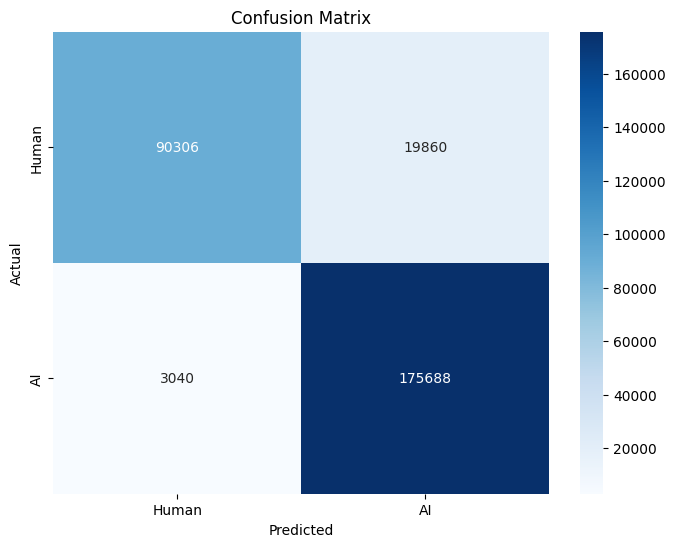

In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred_probs = classification_model.predict([np.array(dev_input_ids), np.array(dev_encodings_attention)])
y_pred = (y_pred_probs > 0.5).astype(int) 

print("Classification Report:")
print(classification_report(dev_labels, y_pred))

cm = confusion_matrix(dev_labels, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Human', 'AI'], yticklabels=['Human', 'AI'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


In [18]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score

languages = train_df['lang'].unique()

language_accuracy = {}

dev_df = dev_df.copy()
dev_df['predictions'] = y_pred

for lang in languages:
    lang_filter = dev_df['lang'] == lang
    lang_predictions = dev_df.loc[lang_filter, 'predictions']
    lang_true_labels = dev_df.loc[lang_filter, 'label']
    
    if len(lang_true_labels) > 0:  # Check if there are true labels for this language
        accuracy = accuracy_score(lang_true_labels, lang_predictions)
        language_accuracy[lang] = accuracy

accuracy_df = pd.DataFrame.from_dict(language_accuracy, orient='index', columns=['Accuracy'])
accuracy_df.index.name = 'Language'
accuracy_df.reset_index(inplace=True)

print(accuracy_df)


  Language  Accuracy
0       en  0.917036
1       zh  0.955524
2       de  0.977659
3       id  0.956184
4       it  1.000000
5       bg  0.914302
6       ar  0.955850
7       ur  0.997457
8       ru  0.915000


In [21]:
from tensorflow.keras.models import load_model 

deberta_model = tf.keras.models.load_model('/kaggle/input/mylstmmodel/tensorflow2/default/1/derberta_model.h5')
import pickle
batch_size = 32
with open('/kaggle/input/deberta-dev/dev_encoding.pkl', 'rb') as file:
    dev_encodings = pickle.load(file)
    
dev_input_ids_deberta_tensor = tf.convert_to_tensor(np.array(dev_encodings).squeeze())

dev_labels_tensor = tf.convert_to_tensor(dev_labels)

dev_dataset = tf.data.Dataset.from_tensor_slices((dev_input_ids_deberta_tensor, dev_labels_tensor)).batch(batch_size)
y_pred_probs_deberta = deberta_model.predict(dev_dataset)
y_pred_deberta = (y_pred_probs_deberta > 0.5).astype(int)

9028/9028 ━━━━━━━━━━━━━━━━━━━━ 47s 5ms/step


In [22]:
y_pred_probs_ensemble = (y_pred_probs_deberta + y_pred_probs) / 2
y_pred_ensemble = (y_pred_probs_ensemble > 0.5).astype(int)

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.92      0.95    110166
           1       0.95      0.98      0.97    178728

    accuracy                           0.96    288894
   macro avg       0.96      0.95      0.96    288894
weighted avg       0.96      0.96      0.96    288894



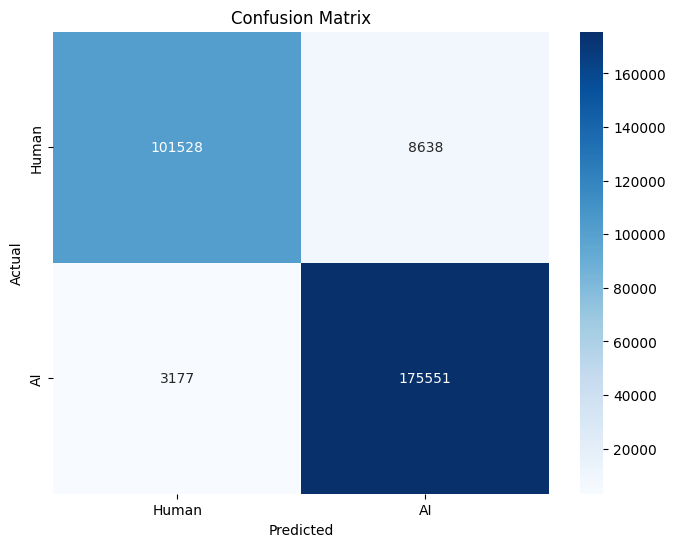

In [23]:
print("Classification Report:")
print(classification_report(dev_labels, y_pred_ensemble))

cm = confusion_matrix(dev_labels, y_pred_ensemble)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Human', 'AI'], yticklabels=['Human', 'AI'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [24]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score

languages = train_df['lang'].unique()

language_accuracy = {}


y_pred = y_pred_ensemble

dev_df = dev_df.copy()
dev_df['predictions'] = y_pred

for lang in languages:
    lang_filter = dev_df['lang'] == lang
    lang_predictions = dev_df.loc[lang_filter, 'predictions']
    lang_true_labels = dev_df.loc[lang_filter, 'label']
    
    if len(lang_true_labels) > 0: 
        accuracy = accuracy_score(lang_true_labels, lang_predictions)
        language_accuracy[lang] = accuracy

accuracy_df = pd.DataFrame.from_dict(language_accuracy, orient='index', columns=['Accuracy'])
accuracy_df.index.name = 'Language'
accuracy_df.reset_index(inplace=True)

print(accuracy_df)


  Language  Accuracy
0       en  0.959125
1       zh  0.963309
2       de  0.963089
3       id  0.963394
4       it  1.000000
5       bg  0.911436
6       ar  0.942605
7       ur  0.997457
8       ru  0.895000
